In [100]:
# Data management
import pandas as pd

# Math and Stat modules
import numpy as np

# Data preprocessing and trasformation (ETL)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

#Imputer
from sklearn.impute import SimpleImputer

#Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve, cross_validate
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#Artificial Neural Network
from tensorflow import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import backend as K

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# Presentazione problema

Partendo dai dati dei clienti di una compagnia cercare di ottimizzare i risultati di una campagna di marketing cercando di predirre chi risponderà positivamente a un'offerta così da massimizzare il profitto della campagna di marketing.

Dataset: [https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign](https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign)

In [2]:
pd.set_option("max_colwidth", 200)
pd.read_csv("data/columnsInfo.csv", sep=";")

,Column's name,Description
0,ID,Customer's id
1,Year_Birth,Customer's year of birth
2,Education,Customer’s level of education
3,Marital_Status,Customer’s marital status
4,Income,Customer’s yearly household income
5,Kidhome,Number of small children in customer’s household
6,Teenhome,Number of teenagers in customer’s household
7,Dt_Customer,Date of customer’s enrolment with the company
8,Recency,Number of days since the last purchase
9,MntWines,Amount spent on wine products in the last 2 years


# ETL Processing

In [3]:
dataset = pd.read_csv("data/marketing_campaign.csv", sep=";")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
dataset.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [5]:
dataset.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'], inplace=True)

Prendo le Label

In [6]:
dataset_label = dataset['Response']
dataset.drop(columns=['Response'], inplace=True)

Guardo come sono distribuiti i dati per preprocessarli

array([[<AxesSubplot:title={'center':'Year_Birth'}>,
        <AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Kidhome'}>,
        <AxesSubplot:title={'center':'Teenhome'}>,
        <AxesSubplot:title={'center':'Recency'}>],
       [<AxesSubplot:title={'center':'MntWines'}>,
        <AxesSubplot:title={'center':'MntFruits'}>,
        <AxesSubplot:title={'center':'MntMeatProducts'}>,
        <AxesSubplot:title={'center':'MntFishProducts'}>,
        <AxesSubplot:title={'center':'MntSweetProducts'}>],
       [<AxesSubplot:title={'center':'MntGoldProds'}>,
        <AxesSubplot:title={'center':'NumDealsPurchases'}>,
        <AxesSubplot:title={'center':'NumWebPurchases'}>,
        <AxesSubplot:title={'center':'NumCatalogPurchases'}>,
        <AxesSubplot:title={'center':'NumStorePurchases'}>],
       [<AxesSubplot:title={'center':'NumWebVisitsMonth'}>,
        <AxesSubplot:title={'center':'AcceptedCmp3'}>,
        <AxesSubplot:title={'center':'AcceptedCmp4'}>,
 

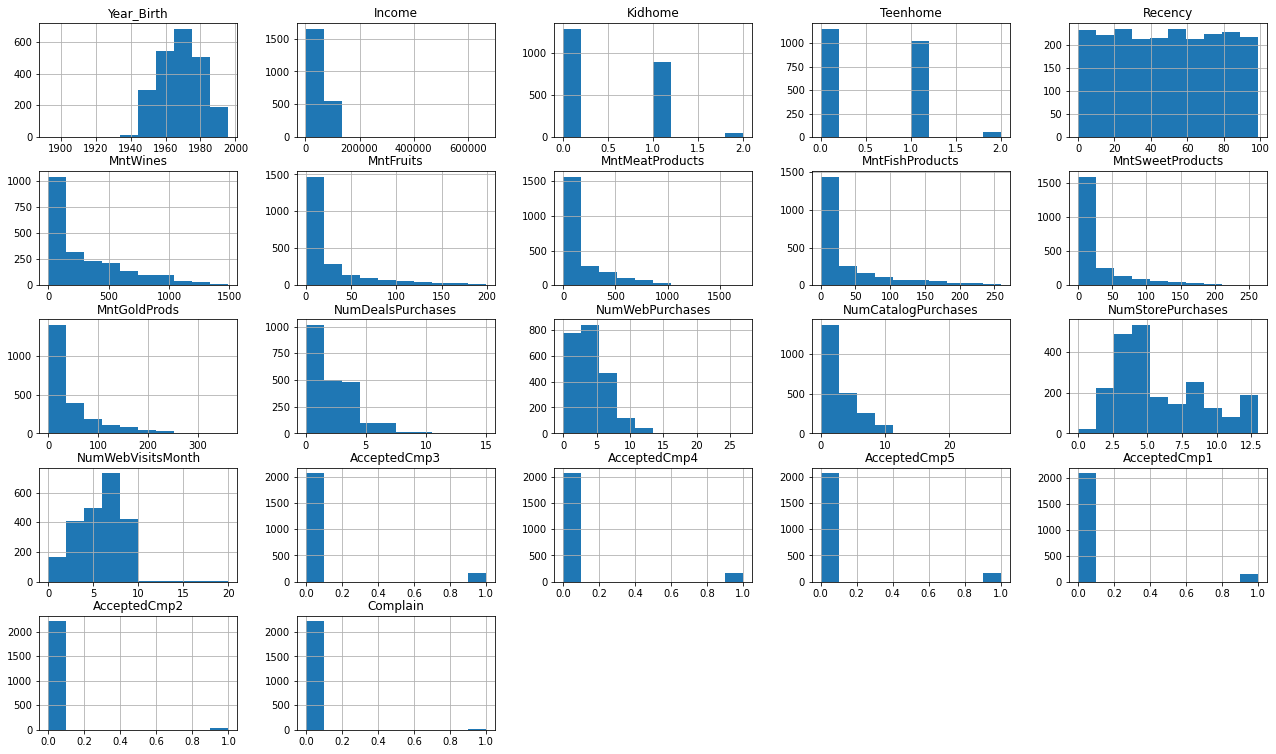

In [7]:
dataset.hist(figsize=(22,13))

In [8]:
class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, startDate = pd.to_datetime("2015-01-01")):
        self.startDate = startDate
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = pd.to_datetime(X.iloc[:,0])
        X_new = pd.DataFrame((self.startDate - X_new).transform(lambda days: days.total_seconds()/(60*60*24*30)))
        return X_new

In [9]:
income_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

date_pipeline = Pipeline([
    ('transformer', DateTransformer()),
    ('scaler', StandardScaler())
])

normal_features = ['Year_Birth', 'NumWebVisitsMonth', 'NumWebPurchases', 'NumCatalogPurchases', 'NumDealsPurchases', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

In [10]:
data_preprocessing = ColumnTransformer([
    ('normal', MinMaxScaler(), normal_features),
    ('cat', OneHotEncoder(), ['Education', 'Marital_Status']),
    ('income', income_pipeline, ['Income']),
    ('dateSubscription', date_pipeline, ["Dt_Customer"]),
    ('sparse', MaxAbsScaler(), ['Recency', 'NumStorePurchases'])
],
    remainder = 'passthrough'
)

feature_matrix = data_preprocessing.fit_transform(dataset)

# Training e Test Sets

In [150]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, dataset_label, test_size = 0.2, random_state = 42)

# Algoritmi/modelli da utilizzare

Si utilizzeranno i seguenti modelli di ML:
- Perceptron
- Logistic Regression 
- Support Vector Machine
- Decision Tree
- Bagging con Decision Tree
- Ada Boost con Decision Tree
- Gradient Boosting
- Random Forest
- Extra Tree

In [186]:
final_scores = [] #Name, predictions, train_size, train_scores, test_scores

skf = StratifiedKFold(n_splits=5)

def drawAccuracy(train_size, train_scores, test_scores):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig=plt.figure(figsize=(12,7))
    ax = fig.add_subplot()

    ax.plot(train_size, train_mean,
             color='blue', marker='+',
             markersize=5, label='Training accuracy')

    ax.fill_between(train_size,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    ax.plot(train_size, test_mean,
             color='green', linestyle='--',
             marker='d', markersize=5,
             label='Validation accuracy')

    ax.fill_between(train_size,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    ax.grid()
    ax.set_xlabel('Dimensione del training set')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_ylim([0.6, 1.03])

## Perceptron

In [218]:
perceptron_cls = Perceptron()

perceptron_prediction = cross_val_predict(perceptron_cls, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(perceptron_cls, X=feature_matrix, y=dataset_label, train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv = skf, n_jobs = -1)

In [219]:
perceptron_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [214]:
# perceptron_cls = Perceptron()
scores = cross_validate(perceptron_cls, feature_matrix, dataset_label,
                        cv = skf,
                        return_estimator = True,
                        return_train_score= True,
                        scoring = ['recall','accuracy','f1', 'precision'],
                        n_jobs=-1)

In [215]:
scores

{'fit_time': array([0.00300312, 0.00300121, 0.00399852, 0.00499988, 0.00399971]),
 'score_time': array([0.00299716, 0.00499749, 0.00299835, 0.00500512, 0.00500512]),
 'estimator': [Perceptron(),
  Perceptron(),
  Perceptron(),
  Perceptron(),
  Perceptron()],
 'test_recall': array([0.29850746, 0.13432836, 0.14925373, 0.58208955, 0.87878788]),
 'train_recall': array([0.28838951, 0.05243446, 0.16853933, 0.75280899, 0.8619403 ]),
 'test_accuracy': array([0.87053571, 0.86160714, 0.86160714, 0.80357143, 0.66517857]),
 'train_accuracy': array([0.88002232, 0.83984375, 0.86104911, 0.81417411, 0.66462054]),
 'test_f1': array([0.40816327, 0.225     , 0.24390244, 0.46987952, 0.43609023]),
 'train_f1': array([0.41734417, 0.08888889, 0.26548673, 0.54693878, 0.434619  ]),
 'test_precision': array([0.64516129, 0.69230769, 0.66666667, 0.39393939, 0.29      ]),
 'train_precision': array([0.75490196, 0.29166667, 0.625     , 0.42948718, 0.29056604])}

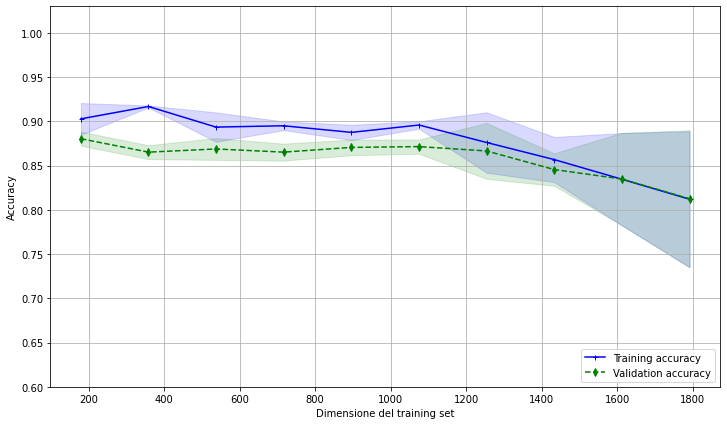

In [216]:
drawAccuracy(train_size, train_scores, test_scores)

In [217]:
final_scores.append(("Perceptron", perceptron_prediction, train_size, train_scores, test_scores))

## Logistic Regression

In [16]:
logit_cls = LogisticRegression(max_iter=1000)

logit_prediction = cross_val_predict(logit_cls, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(logit_cls, X=feature_matrix, y=dataset_label, train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv = skf, n_jobs = -1)

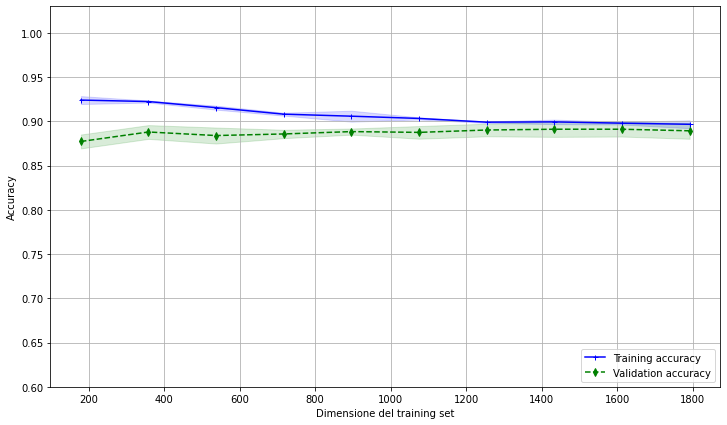

In [17]:
drawAccuracy(train_size, train_scores, test_scores)

In [18]:
final_scores.append(("Logistic Regression", logit_prediction, train_size, train_scores, test_scores))

## SVC

In [19]:
gamma1, gamma2 = 0.1, 2
C1, C2 = 0.01, 5
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

train_sizes, train_means, test_means, test_stds, train_stds, SVC_predictions = [],[],[],[],[],[]
for gamma, C in hyperparams:
    svc_cls = SVC(kernel="rbf", gamma = gamma, C = C)
    svc_prediction = cross_val_predict(svc_cls, X_train, y_train, cv = skf)
    train_size, train_scores, test_scores = learning_curve(svc_cls, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv=skf, n_jobs=-1)
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

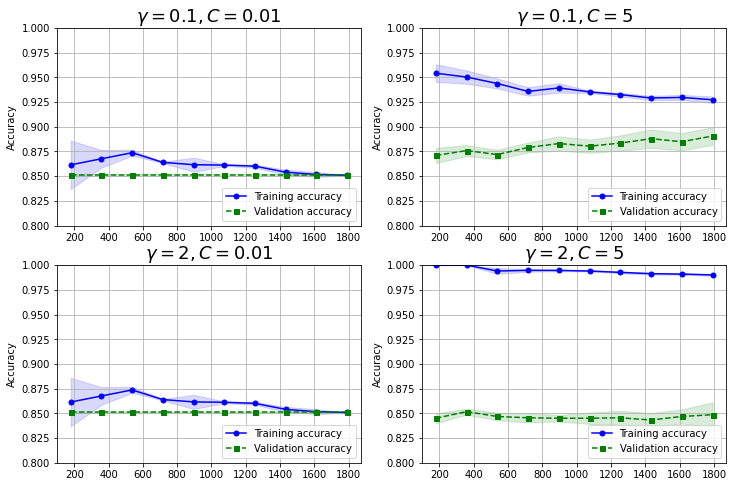

In [20]:
fig= plt.figure(figsize=(12, 8))
for i in range(4):
    ax = fig.add_subplot(221+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.8,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"$\gamma={}, C={}$".format(*hyperparams[i]), fontsize=18)

In [21]:
svc_cls = SVC(kernel="rbf", gamma = 0.1, C = 2)
svc_prediction = cross_val_predict(svc_cls, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(svc_cls, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv=skf, n_jobs=-1)

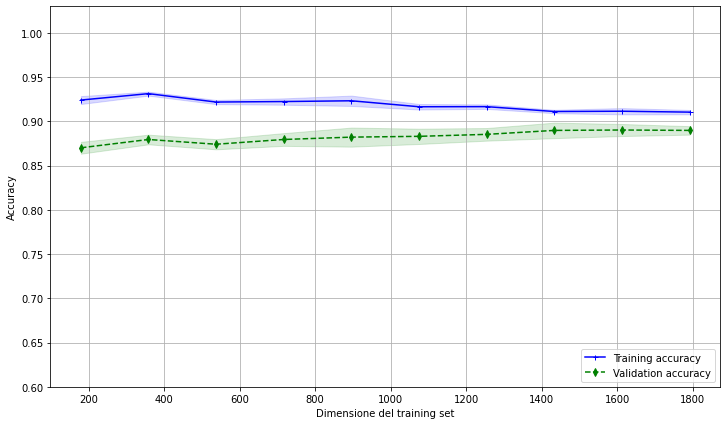

In [22]:
drawAccuracy(train_size, train_scores, test_scores)

In [23]:
final_scores.append(("SVC", svc_prediction, train_size, train_scores, test_scores))

## Decision Tree

In [24]:
min_leaf = [20, 30, 40, 50, 100]

train_sizes, train_means, test_means, test_stds, train_stds = [],[],[],[],[]
for mlf in min_leaf:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=mlf, random_state=42, max_depth=15)
    dt_prediction = cross_val_predict(dt_clf, X_train, y_train, cv = skf)
    train_size, train_scores, test_scores = learning_curve(dt_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv=skf, n_jobs=-1)
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

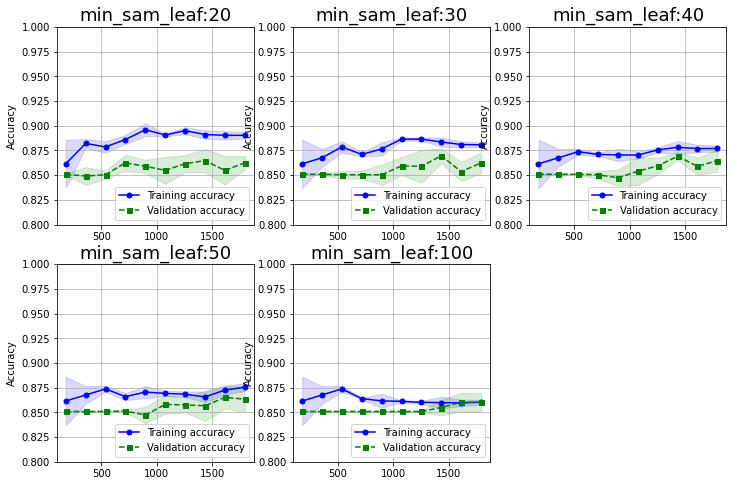

In [25]:
fig= plt.figure(figsize=(12, 8))
for i in range(5):
    ax = fig.add_subplot(231+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.8,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"min_sam_leaf:{}".format(min_leaf[i]), fontsize=18)

In [26]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=40, random_state=42, max_depth=15)
dt_prediction = cross_val_predict(dt_clf, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(dt_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv=skf, n_jobs=-1)

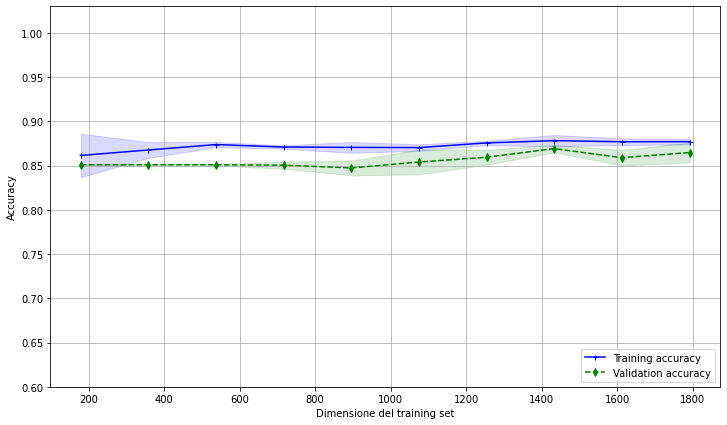

In [27]:
drawAccuracy(train_size, train_scores, test_scores)

In [28]:
final_scores.append(("Decision Tree", dt_prediction, train_size, train_scores, test_scores))

## Bagging

In [29]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=250, max_samples=100, bootstrap=True, n_jobs=-1)

bagging_prediction = cross_val_predict(bag_clf, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(bag_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = skf, n_jobs = -1)

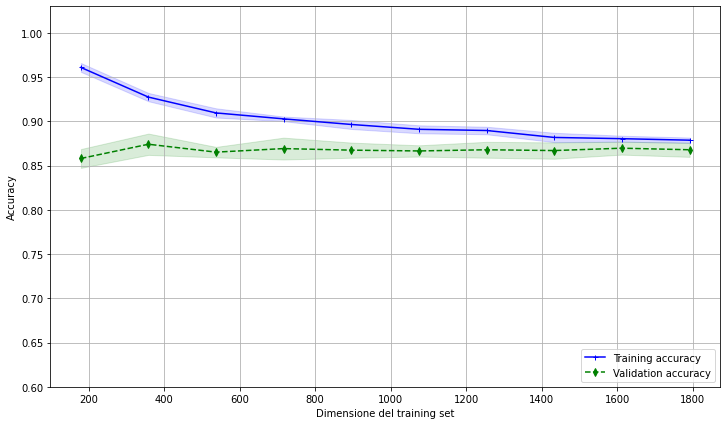

In [30]:
drawAccuracy(train_size, train_scores, test_scores)

In [31]:
final_scores.append(("Bagging", bagging_prediction, train_size, train_scores, test_scores))

## Ada Boost

In [32]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=60), n_estimators=250, algorithm='SAMME.R', learning_rate=1)

ada_prediction = cross_val_predict(ada_clf, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(ada_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = skf, n_jobs = -1)

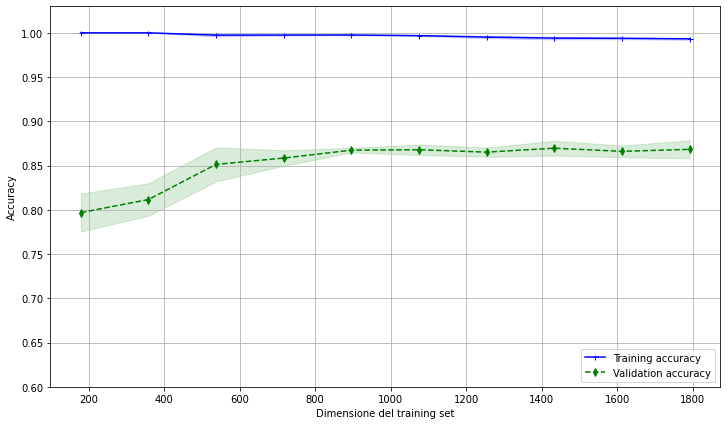

In [33]:
drawAccuracy(train_size, train_scores, test_scores)

In [34]:
final_scores.append(("Ada Boost", ada_prediction, train_size, train_scores, test_scores))

## Gradient Boosting

In [35]:
gb_clf = GradientBoostingClassifier(n_estimators=350, max_leaf_nodes=2, max_features=10)

gb_prediction = cross_val_predict(gb_clf, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(gb_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = skf, n_jobs = -1)

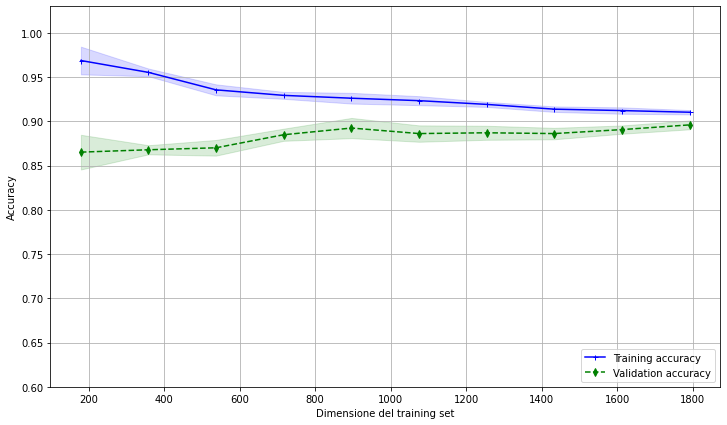

In [36]:
drawAccuracy(train_size, train_scores, test_scores)

In [37]:
final_scores.append(("Gradient Boosting", gb_prediction, train_size, train_scores, test_scores))

## Random Forest

In [38]:
rnf_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=20, n_jobs=-1, max_features=10)

rand_forest_prediction = cross_val_predict(rnf_clf, X_train, y_train, cv = skf)
train_size, train_scores, test_scores = learning_curve(rnf_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = skf, n_jobs = -1)

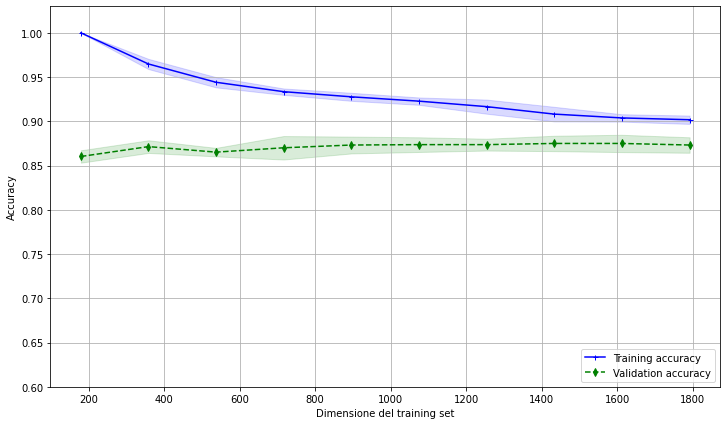

In [39]:
drawAccuracy(train_size, train_scores, test_scores)

In [40]:
final_scores.append(("Random Forest", rand_forest_prediction, train_size, train_scores, test_scores))

## Extra Trees

In [41]:
et_clf = ExtraTreesClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, max_features=10)

extra_trees_prediction = cross_val_predict(et_clf, X_train, y_train, cv = skf)
train_sizes, train_scores, test_scores = learning_curve(et_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = skf, n_jobs = -1)

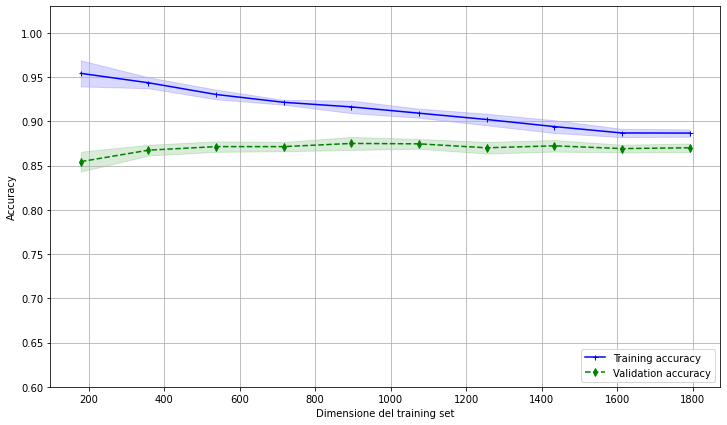

In [42]:
drawAccuracy(train_size, train_scores, test_scores)

In [43]:
final_scores.append(("Extra Trees", extra_trees_prediction, train_size, train_scores, test_scores))

# Cross-validation

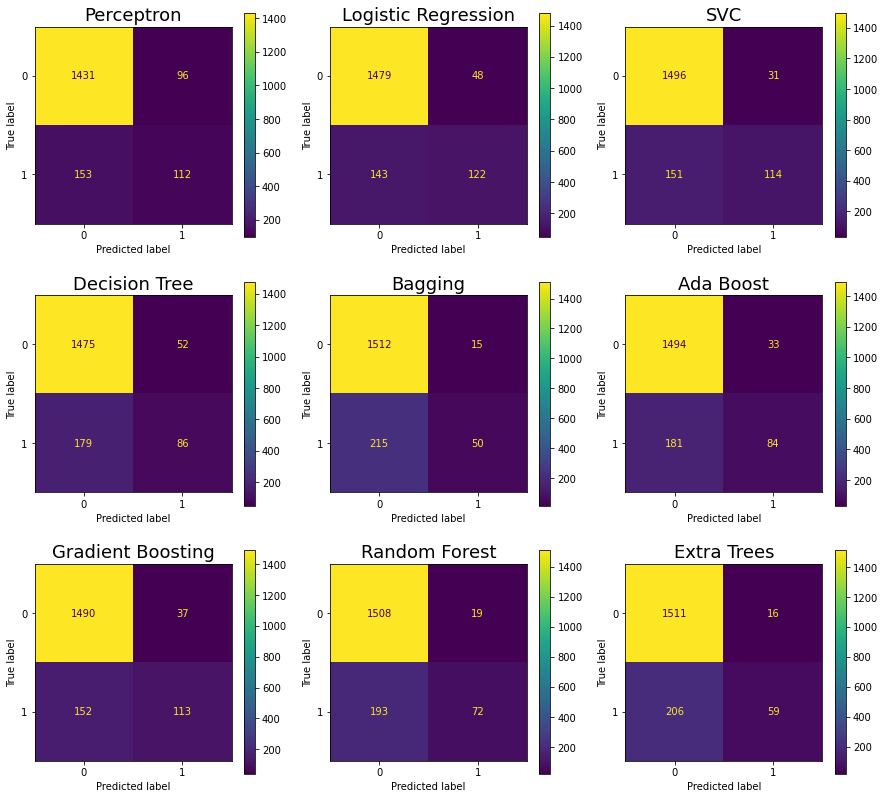

In [44]:
fig= plt.figure(figsize=(15, 14))
for i, (name, prediction, train_size, train_scores, test_scores) in enumerate(final_scores):
    ax = fig.add_subplot(331+i)
    cm = confusion_matrix(y_train, prediction)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    ax.set_title(name, fontsize=18)

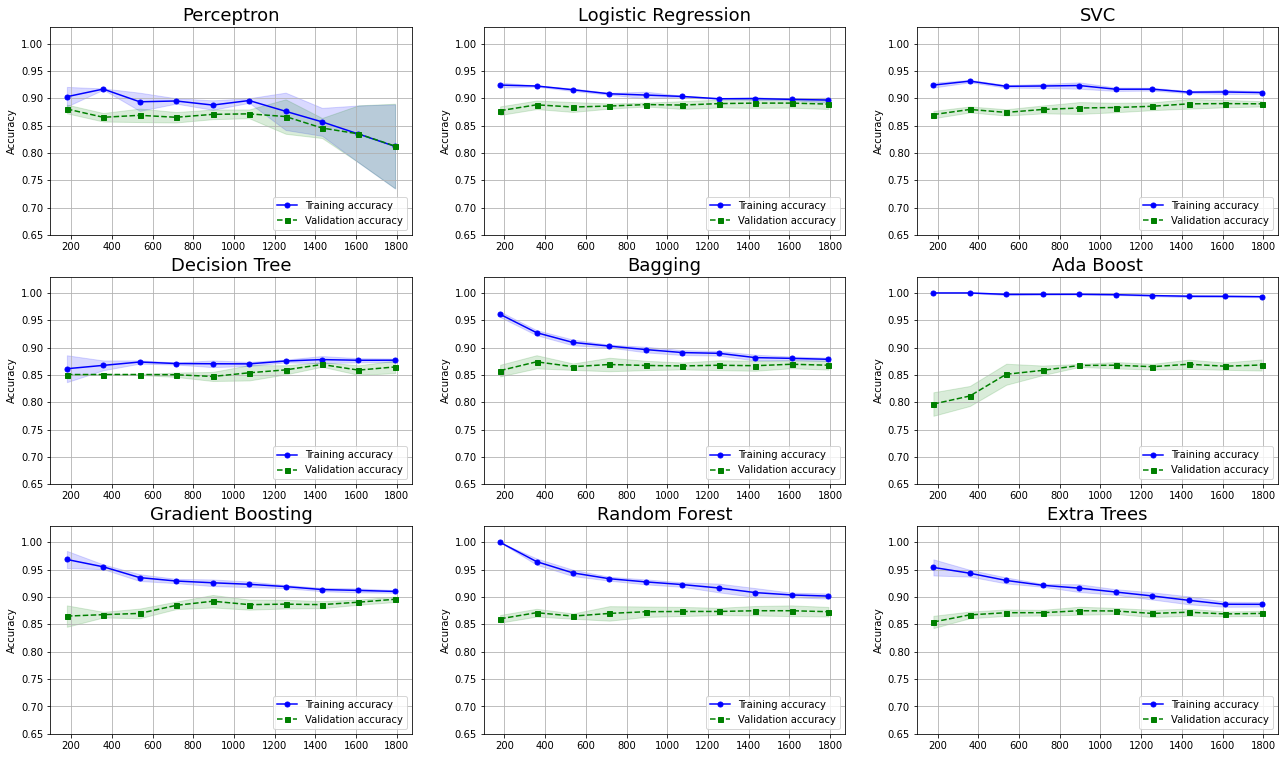

In [45]:
fig= plt.figure(figsize=(22, 13))
for i, (name, prediction, train_size, train_scores, test_scores) in enumerate(final_scores):
    if name == "Neural network":
        continue
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax = fig.add_subplot(331+i)
    ax.plot(train_size, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_size,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
    ax.plot(train_size, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_size,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.65,1.03))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(name, fontsize=18)

In [46]:
columns = ["Accuracy", "Precision", "Recall", "F1"]
final_table = pd.DataFrame(columns=columns)
for (name, prediction, train_size, train_scores, test_scores) in final_scores:
    accuracy = accuracy_score(y_train, prediction)
    precision = precision_score(y_train, prediction)
    recall = recall_score(y_train, prediction)
    f1 = f1_score(y_train, prediction)
    data = [accuracy, precision, recall, f1]
    final_table = pd.concat([final_table, pd.DataFrame([data], columns=columns, index=[name])])

In [47]:
dfstyle = [dict(selector="th", props=[('font-size', '20pt')]),dict(selector="td", props=[('font-size', '20pt')])]
final_table.style.set_table_styles(dfstyle).background_gradient(axis=0, cmap=sns.light_palette("green", as_cmap=True))

,Accuracy,Precision,Recall,F1
Perceptron,0.861049,0.538462,0.422642,0.473573
Logistic Regression,0.893415,0.717647,0.460377,0.560920
SVC,0.898438,0.786207,0.430189,0.556098
Decision Tree,0.871094,0.623188,0.324528,0.426799
Bagging,0.871652,0.769231,0.188679,0.303030
Ada Boost,0.880580,0.717949,0.316981,0.439791
Gradient Boosting,0.894531,0.753333,0.426415,0.544578
Random Forest,0.881696,0.791209,0.271698,0.404494
Extra Trees,0.876116,0.786667,0.222642,0.347059


<AxesSubplot:>

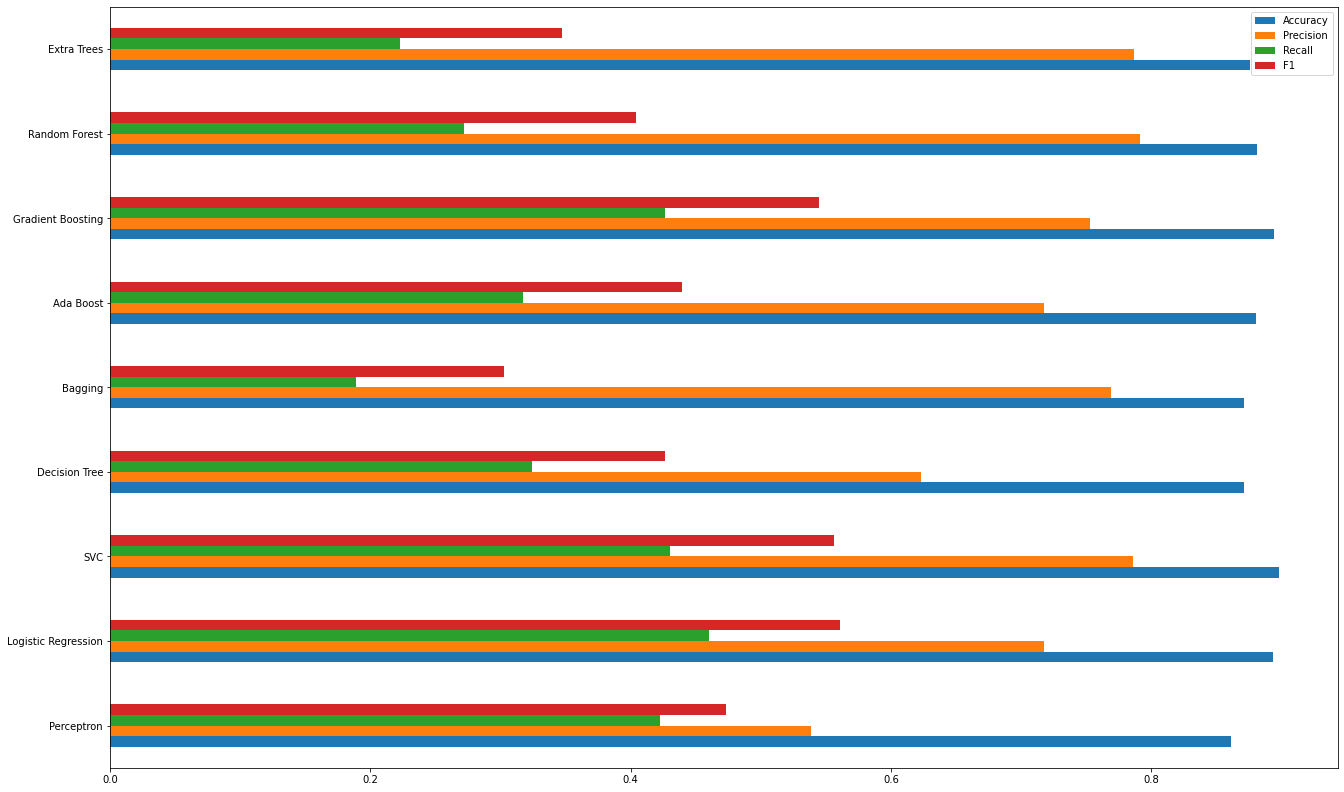

In [48]:
final_table.plot(kind="barh", figsize=(22,14))

# Conclusioni

ALTA PRECISION = Alta probabilità di successo ma rischio di non contattare potenziali clienti interessati all'offerta

ALTA RECALL = Probabilità più bassa di successo ma rischio minore di non contattare potenziali clienti interessati all'offerta 

Per il contesto nel quale ci troviamo probabilmente preferiremmo avere una f1 alta ma se dovessimo scegliere una recall alta è preferibile rispetto a una precision alta dato che contattare potenziali clienti interessati all'offerta porterebbe un profitto maggiore al costo di scomodare clienti non interessati e però avere una campagna di marketing più costosa.

Dato che il **Perceptron** è quello con la recall più alta ma ha gli altri valori abbastanza bassi sceglieremo il **Gradient Boosting** dato che è il secondo modello con la recall più alta e tutti gli altri valori alti.

# Artificial Neural Network

In [94]:
X_train_dnn, X_valid_dnn, y_train_dnn, y_valid_dnn = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)
X_train_dnn.shape, X_valid_dnn.shape, y_train_dnn.shape, y_valid_dnn.shape

((1433, 36), (359, 36), (1433,), (359,))

In [133]:
model = keras.models.Sequential([
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1, activation="relu")
])

In [134]:
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,
                                                  restore_best_weights=True)

history = model.fit(X_train_dnn, y_train_dnn, epochs=13,
                    validation_data=(X_valid_dnn, y_valid_dnn),
                    callbacks=[early_stopping_cb])

y_pred1 = model.predict(X_test)
dnn_prediction = np.argmax(y_pred1, axis=1)

Epoch 1/13
45/45 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.8535 - val_loss: 0.1437 - val_accuracy: 0.8468
Epoch 2/13
45/45 [==============================] - 0s 1ms/step - loss: 0.1244 - accuracy: 0.8548 - val_loss: 0.1430 - val_accuracy: 0.8468
Epoch 3/13
45/45 [==============================] - 0s 1ms/step - loss: 0.1236 - accuracy: 0.8548 - val_loss: 0.1424 - val_accuracy: 0.8468
Epoch 4/13
45/45 [==============================] - 0s 1ms/step - loss: 0.1229 - accuracy: 0.8548 - val_loss: 0.1416 - val_accuracy: 0.8468
Epoch 5/13
45/45 [==============================] - 0s 1ms/step - loss: 0.1222 - accuracy: 0.8555 - val_loss: 0.1409 - val_accuracy: 0.8468
Epoch 6/13
45/45 [==============================] - 0s 1ms/step - loss: 0.1215 - accuracy: 0.8562 - val_loss: 0.1402 - val_accuracy: 0.8468
Epoch 7/13
45/45 [==============================] - 0s 1ms/step - loss: 0.1208 - accuracy: 0.8548 - val_loss: 0.1396 - val_accuracy: 0.8468
Epoch 8/13
45/45 [==

In [135]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 20)                740       
                                                                 
 dense_29 (Dense)            (None, 1)                 21        
                                                                 
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________


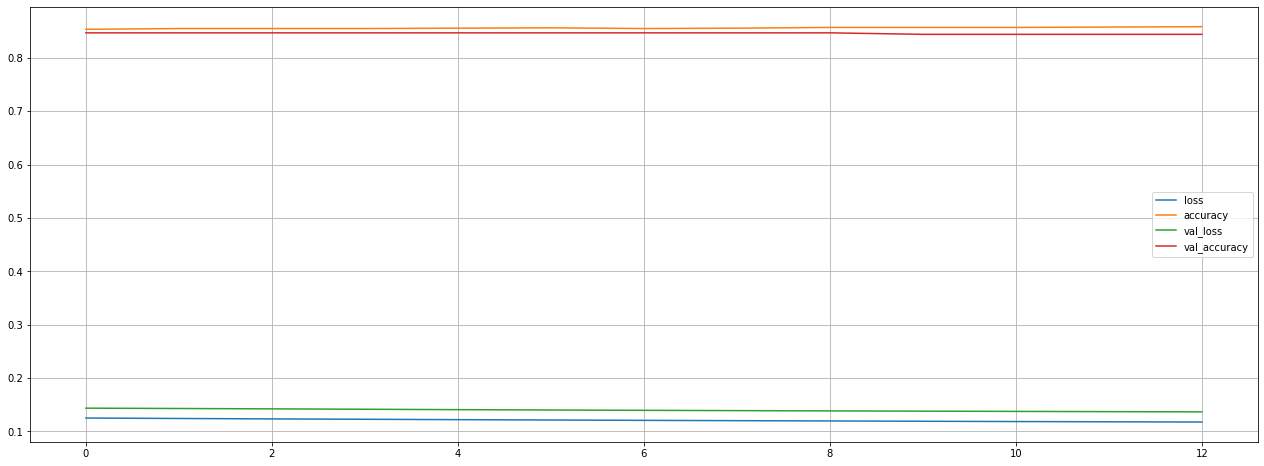

In [136]:
pd.DataFrame(history.history).plot(figsize=(22,8))
plt.grid(True)

In [138]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.8527


[0.12456562370061874, 0.8526785969734192]

In [139]:
final_scores.append(("Neural Network", dnn_prediction, None, None, None))

In [140]:
columns = ["Accuracy", "Precision", "Recall", "F1"]
final_table = pd.DataFrame(columns=columns)
for (name, prediction, train_size, train_scores, test_scores) in final_scores:
    accuracy = accuracy_score(y_train, prediction)
    precision = precision_score(y_train, prediction)
    recall = recall_score(y_train, prediction)
    f1 = f1_score(y_train, prediction)
    data = [accuracy, precision, recall, f1]
    final_table = pd.concat([final_table, pd.DataFrame([data], columns=columns, index=[name])])

ValueError: Found input variables with inconsistent numbers of samples: [1792, 448]

In [141]:
dfstyle = [dict(selector="th", props=[('font-size', '20pt')]),dict(selector="td", props=[('font-size', '20pt')])]
final_table.style.set_table_styles(dfstyle).background_gradient(axis=0, cmap=sns.light_palette("green", as_cmap=True))

,Accuracy,Precision,Recall,F1
Perceptron,0.861049,0.538462,0.422642,0.473573
Logistic Regression,0.893415,0.717647,0.460377,0.560920
SVC,0.898438,0.786207,0.430189,0.556098
Decision Tree,0.871094,0.623188,0.324528,0.426799
Bagging,0.871652,0.769231,0.188679,0.303030
Ada Boost,0.880580,0.717949,0.316981,0.439791
Gradient Boosting,0.894531,0.753333,0.426415,0.544578
Random Forest,0.881696,0.791209,0.271698,0.404494
Extra Trees,0.876116,0.786667,0.222642,0.347059
